# Getting Started

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib

In [2]:
# load the pre-processed dataset
# Adult Mouse Brain (Coronal)
# for more details, visit: https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Adult_Mouse_Brain?
#               https://www.10xgenomics.com/datasets/adult-mouse-brain-coronal-section-fresh-frozen-1-standard
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

In [3]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

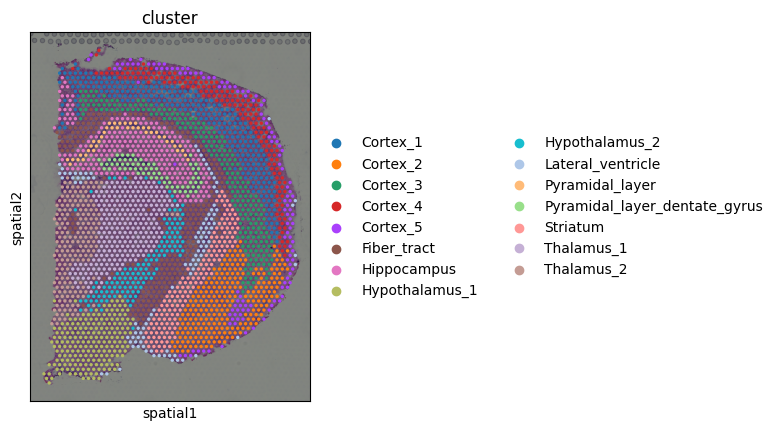

In [4]:
sc.pl.spatial(adata, color = 'cluster')

# CellDART

In [5]:
# Import CellDART packages
'''
! git clone https://github.com/mexchy1000/CellDART.git
'''
import os
import sys

sys.path.insert(0, os.path.abspath("./CellDART/CellDART"))
import da_cellfraction
import pred_cellf_celldart
from utils import *

In [6]:
# Takes long time
scRNA_seq_reference = sc.read_csv('GSE115746_cells_exon_counts.csv').T

scRNA_seq_reference_meta = pd.read_csv('GSE115746_complete_metadata_28706-cells.csv', index_col=0)
scRNA_seq_reference_meta_ = scRNA_seq_reference_meta.loc[scRNA_seq_reference.obs.index,]
scRNA_seq_reference.obs = scRNA_seq_reference_meta_
scRNA_seq_reference.var_names_make_unique()

In [7]:
scRNA_seq_reference.var['mt'] = scRNA_seq_reference.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scRNA_seq_reference, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(scRNA_seq_reference)

/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


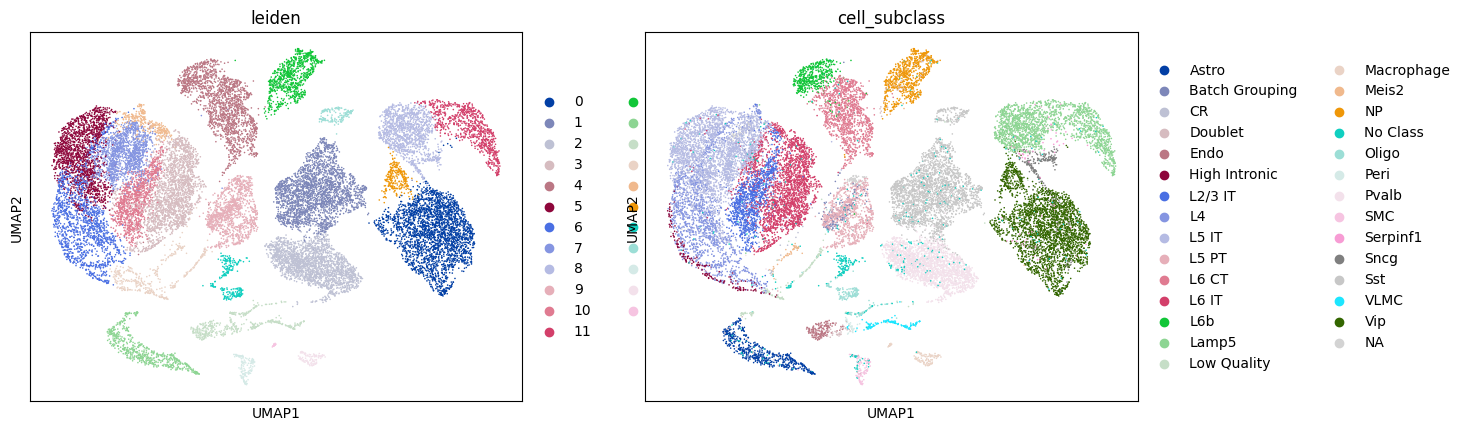

In [8]:
sc.tl.pca(scRNA_seq_reference, svd_solver='arpack')
sc.pp.neighbors(scRNA_seq_reference, n_neighbors=10, n_pcs=40)
sc.tl.umap(scRNA_seq_reference)
sc.tl.leiden(scRNA_seq_reference, resolution = 0.5)
sc.pl.umap(scRNA_seq_reference, color=['leiden','cell_subclass'])

/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered

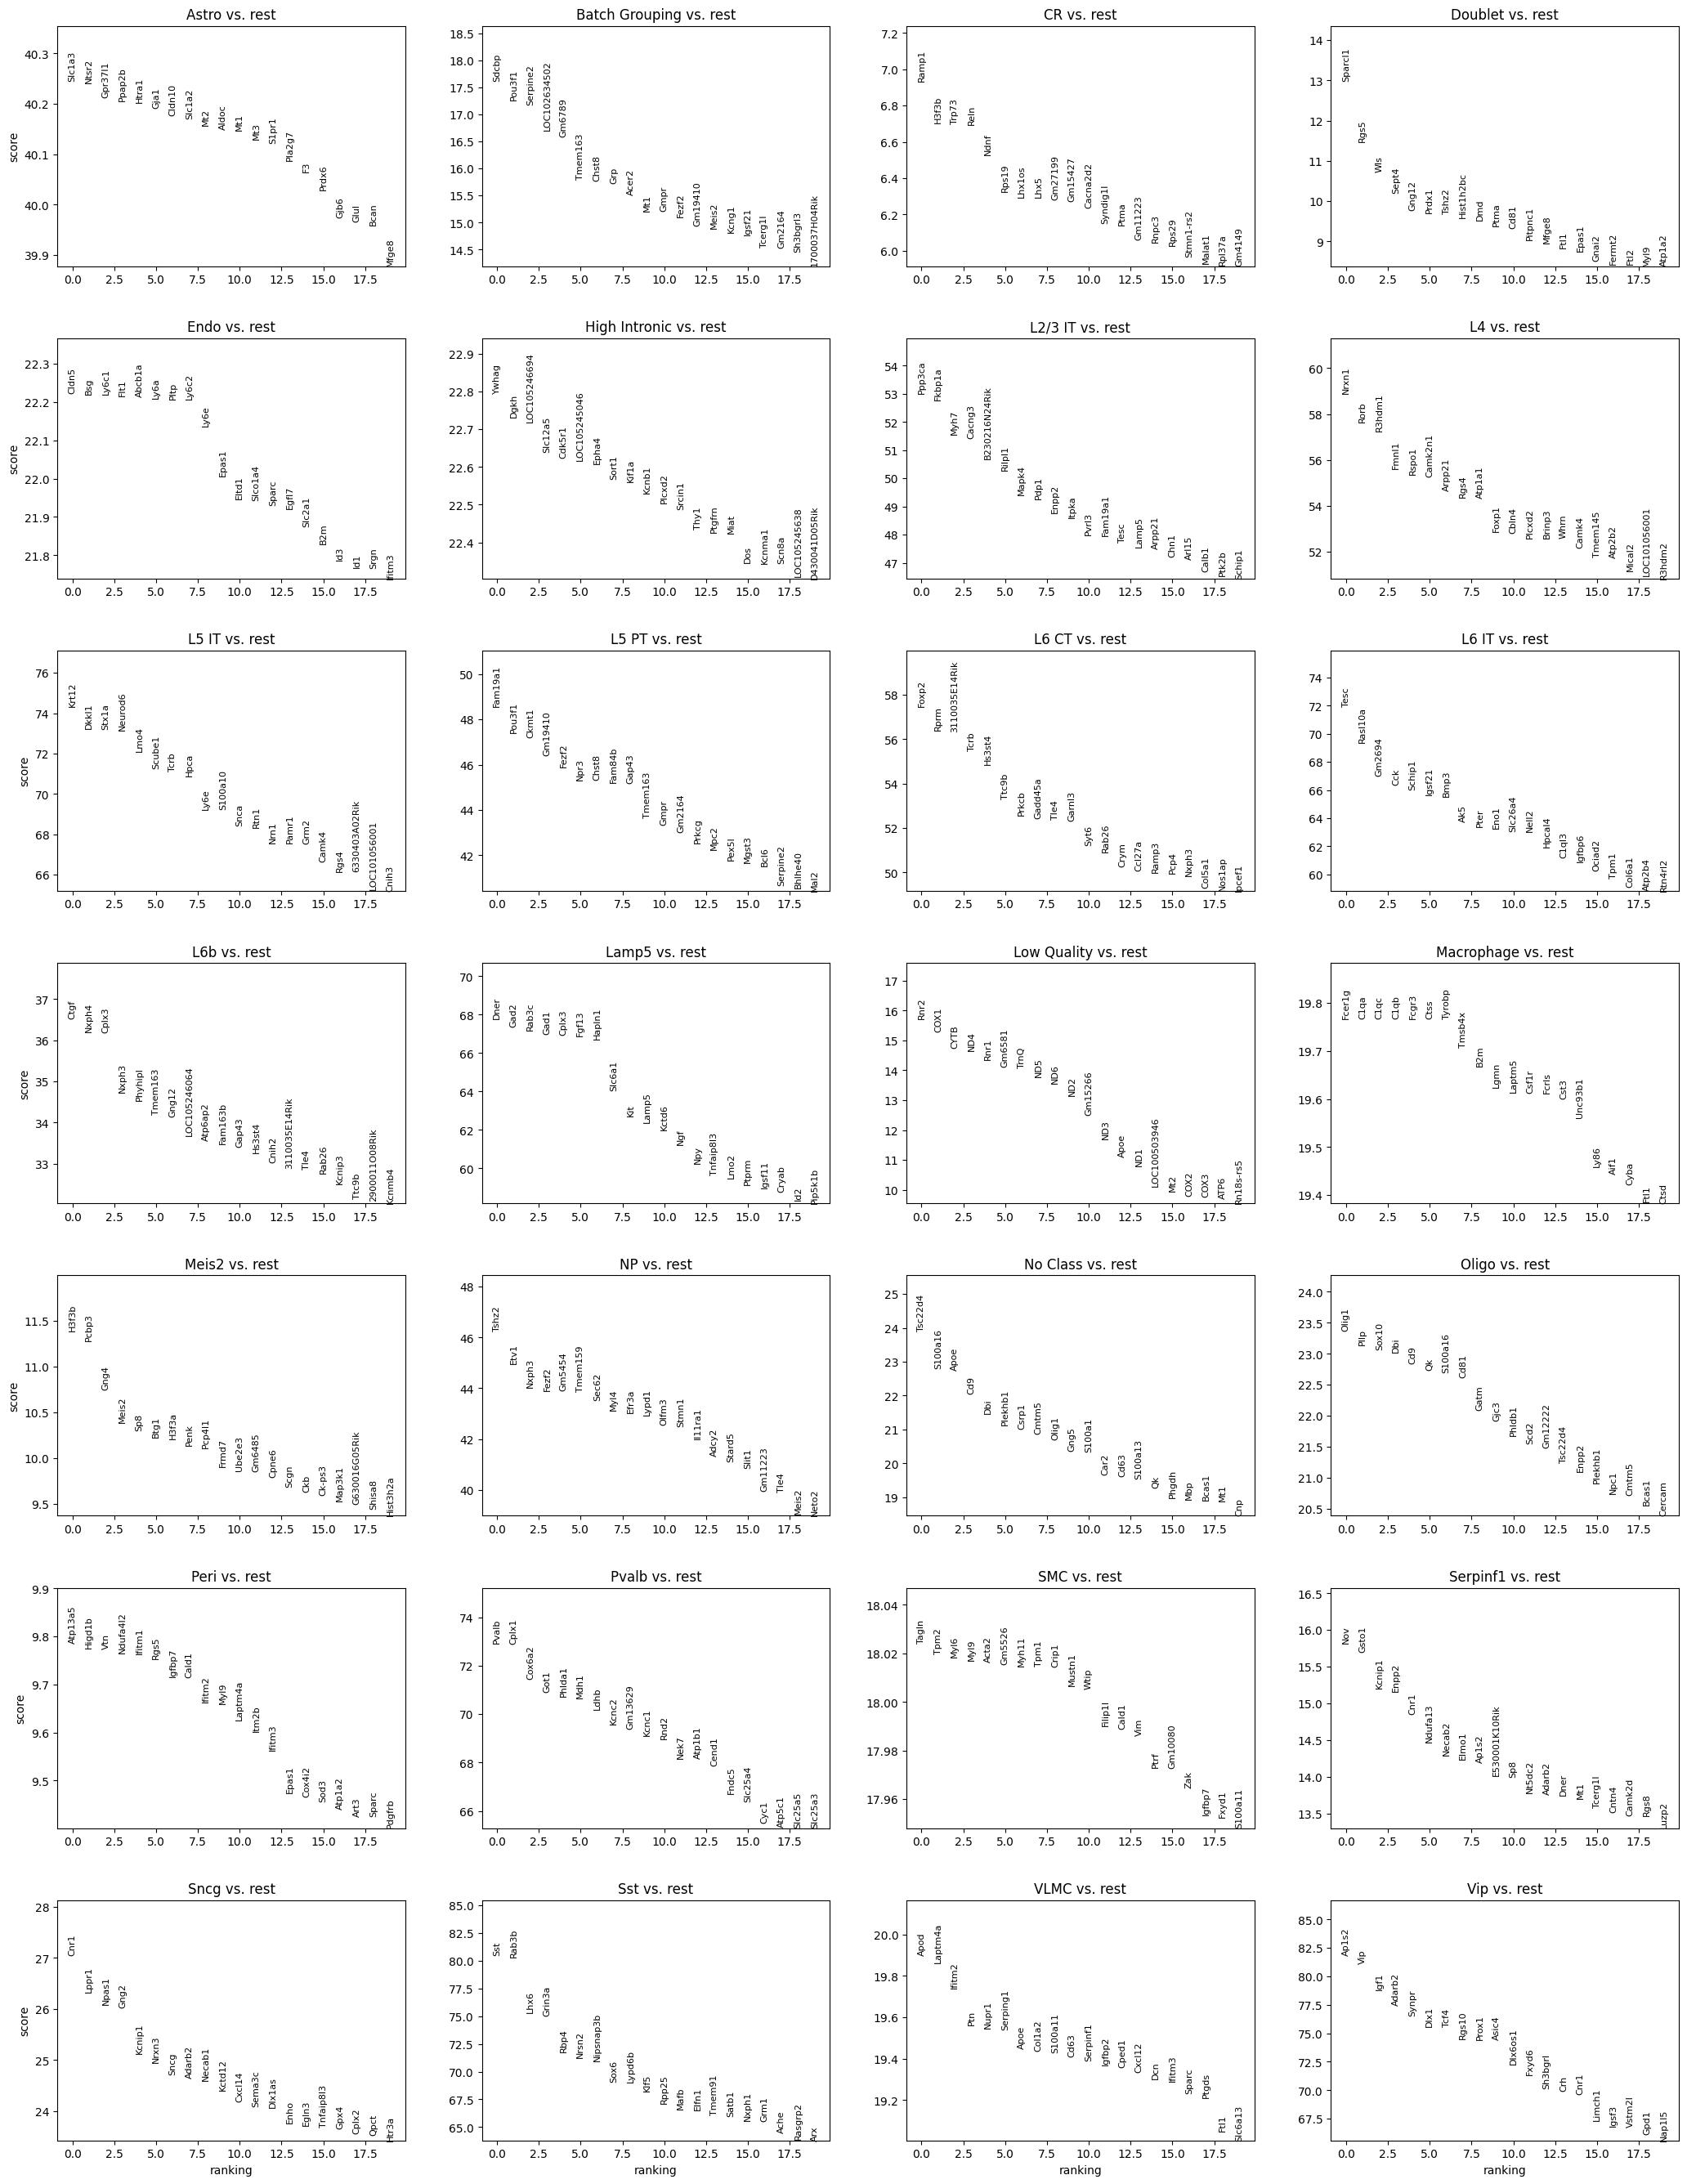

In [9]:
sc.tl.rank_genes_groups(scRNA_seq_reference, 'cell_subclass', method='wilcoxon')
sc.pl.rank_genes_groups(scRNA_seq_reference, n_genes=20, sharey=False)

In [10]:
genelists=scRNA_seq_reference.uns['rank_genes_groups']['names']
df_genelists = pd.DataFrame.from_records(genelists)
df_genelists.head(5)

,Astro,Batch Grouping,CR,Doublet,Endo,High Intronic,L2/3 IT,L4,L5 IT,L5 PT,...,No Class,Oligo,Peri,Pvalb,SMC,Serpinf1,Sncg,Sst,VLMC,Vip
0,Slc1a3,Sdcbp,Ramp1,Sparcl1,Cldn5,Ywhag,Ppp3ca,Nrxn1,Krt12,Fam19a1,...,Tsc22d4,Olig1,Atp13a5,Pvalb,Tagln,Nov,Cnr1,Sst,Apod,Ap1s2
1,Ntsr2,Pou3f1,H3f3b,Rgs5,Bsg,Dgkh,Fkbp1a,Rorb,Dkkl1,Pou3f1,...,S100a16,Pllp,Higd1b,Cplx1,Tpm2,Gsto1,Lppr1,Rab3b,Laptm4a,Vip
2,Gpr37l1,Serpine2,Trp73,Wls,Ly6c1,LOC105246694,Myh7,R3hdm1,Stx1a,Ckmt1,...,Apoe,Sox10,Vtn,Cox6a2,Myl6,Kcnip1,Npas1,Lhx6,Ifitm2,Igf1
3,Ppap2b,LOC102634502,Reln,Sept4,Flt1,Slc12a5,Cacng3,Fmnl1,Neurod6,Gm19410,...,Cd9,Dbi,Ndufa4l2,Got1,Myl9,Enpp2,Gng2,Grin3a,Ptn,Adarb2
4,Htra1,Gm6789,Ndnf,Gng12,Abcb1a,Cdk5r1,B230216N24Rik,Rspo1,Lmo4,Fezf2,...,Dbi,Cd9,Ifitm1,Phlda1,Acta2,Cnr1,Kcnip1,Rbp4,Nupr1,Synpr


In [11]:
num_markers=10
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

In [12]:
adata.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata.var.index]
print('Selected Feature Gene number',len(inter_genes))
scRNA_seq_reference = scRNA_seq_reference[:,inter_genes]
adata = adata[:,inter_genes]

Selected Feature Gene number 231


In [13]:
mat_sc = scRNA_seq_reference.X
mat_sp = adata.X.todense()

df_sc = scRNA_seq_reference.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), set(lab_sc_sub)))
sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

In [14]:
sc_mix, lab_mix = random_mix(mat_sc, lab_sc_num, nmix=5, n_samples=5000)

def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))

sc_mix_s = log_minmaxscale(sc_mix)
mat_sp_s = log_minmaxscale(mat_sp)
mat_sc_s = log_minmaxscale(mat_sc)

In [15]:
embs, clssmodel = da_cellfraction.train(sc_mix_s, lab_mix, mat_sp_s,
                                        alpha=1, alpha_lr=5, emb_dim = 64, batch_size = 512,
                                        n_iterations = 2000,
                                        initial_train=True,
                                        initial_train_epochs=10)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 1s 177us/sample - loss: 1.2673 - mae: 0.0400
Epoch 2/10
5000/5000 [==============================] - 0s 14us/sample - loss: 0.7072 - mae: 0.0277
Epoch 3/10
5000/5000 [==============================] - 0s 14us/sample - loss: 0.5957 - mae: 0.0246
Epoch 4/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.5324 - mae: 0.0227
Epoch 5/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.4843 - mae: 0.0214
Epoch 6/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.4469 - mae: 0.0203
Epoch 7/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.4172 - mae: 0.0195
Epoch 8/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.3907 - mae: 0.0186
Epoch 9/10
5000/5000 [==============================] - 0s 15us/sample - loss: 0.3681 - mae: 0.0180
Epoch 10/10
5000/5000 [==============================] - 0s 15us/sample - los

/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Iteration 99, source loss =  1.476, discriminator acc = 0.022
Iteration 199, source loss =  1.997, discriminator acc = 0.197
Iteration 299, source loss =  1.424, discriminator acc = 0.124
Iteration 399, source loss =  1.230, discriminator acc = 0.113
Iteration 499, source loss =  1.180, discriminator acc = 0.134
Iteration 599, source loss =  1.090, discriminator acc = 0.166
Iteration 699, source loss =  1.820, discriminator acc = 0.237
Iteration 799, source loss =  1.294, discriminator acc = 0.459
Iteration 899, source loss =  0.726, discriminator acc = 0.089
Iteration 999, source loss =  0.727, discriminator acc = 0.176
Iteration 1099, source loss =  0.692, discriminator acc = 0.743
Iteration 1199, source loss =  0.505, discriminator acc = 0.137
Iteration 1299, source loss =  0.534, discriminator acc = 0.214
Iteration 1399, source loss =  0.717, discriminator acc = 0.711
Iteration 1499, source loss =  0.492, discriminator acc = 0.206
Iteration 1599, source loss =  0.515, discriminator

In [16]:
pred_sp = clssmodel.predict(mat_sp_s)

def plot_cellfraction(visnum):
    adata.obs['Pred_label'] = pred_sp[:,visnum]
    sc.pl.spatial(
        adata,
        img_key="hires",
        color='Pred_label',
        palette='Set1',
        size=1.5,
        legend_loc=None,
        title = sc_sub_dict[visnum])

print(sc_sub_dict)

/home/jeongbinpark/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


{0: nan, 1: 'Vip', 2: 'L5 PT', 3: 'L2/3 IT', 4: 'NP', 5: 'L5 IT', 6: 'Sst', 7: 'Macrophage', 8: 'L6 CT', 9: 'Pvalb', 10: 'High Intronic', 11: 'Batch Grouping', 12: 'Low Quality', 13: 'SMC', 14: 'Meis2', 15: 'Endo', 16: 'CR', 17: 'Serpinf1', 18: 'VLMC', 19: 'Peri', 20: 'L6b', 21: 'Doublet', 22: 'Lamp5', 23: 'Astro', 24: 'L4', 25: 'Oligo', 26: 'No Class', 27: 'Sncg', 28: 'L6 IT'}


/tmp/ipykernel_1302602/2756680035.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Pred_label'] = pred_sp[:,visnum]


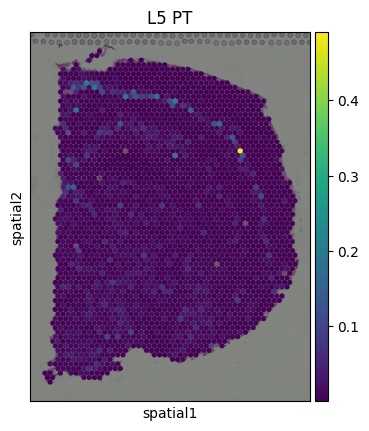

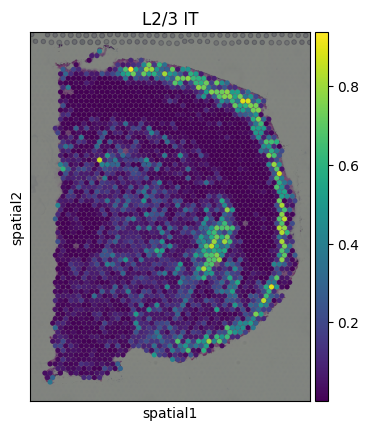

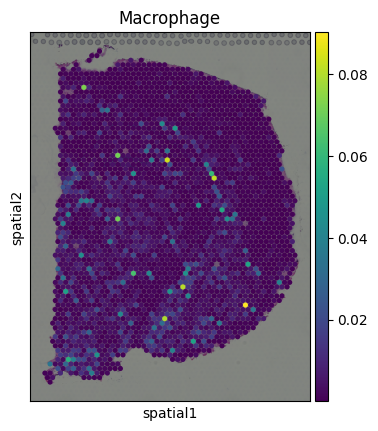

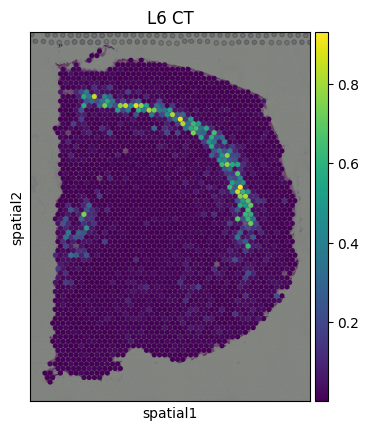

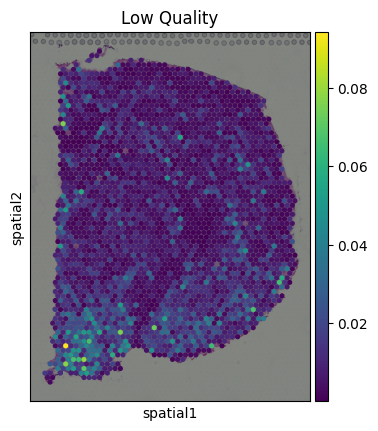

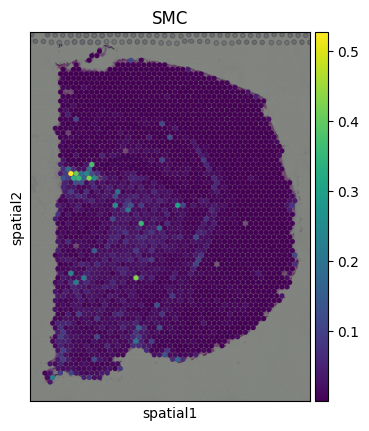

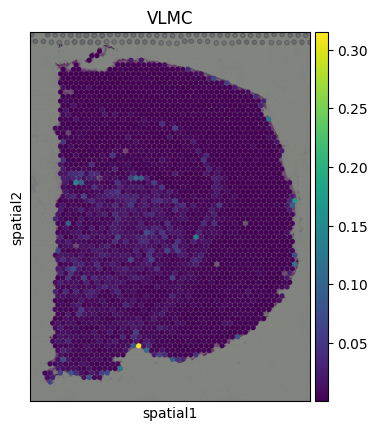

In [17]:
numlist = [2,3,7,8,12,13,18]

for num in numlist:
    plot_cellfraction(num)

# Packages

In [19]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.0.0
aiohappyeyeballs             2.4.4
aiohttp                      3.10.11
aiosignal                    1.3.1
anndata                      0.9.2
anyio                        4.2.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asciitree                    0.3.3
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                5.0.1
attrs                        23.2.0
Babel                        2.14.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.5.0
CellDART                     0.1.1
celltypist                   1.6.3
certifi                      2024.8.30
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.